<a href="https://www.kaggle.com/code/utkarshpandey1112/vehicle-classification-cnn-model?scriptVersionId=296393929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing Libraries

In [2]:
import os
from glob import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


2026-02-07 14:11:29.021356: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770473489.214156      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770473489.276456      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770473489.756360      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770473489.756409      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770473489.756412      24 computation_placer.cc:177] computation placer alr

Configuration

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42


DATASET DIRECTORY


In [4]:
DATASET_DIR = "/kaggle/input/vehicles-image-dataset/vehicle_data"


Collect Image Paths & Labels

In [5]:
image_paths = []
labels = []

class_names = sorted(os.listdir(DATASET_DIR))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_path in glob(class_dir + "/*"):
        image_paths.append(img_path)
        labels.append(class_to_index[class_name])

print("Total images:", len(image_paths))
print("Total classes:", len(class_names))


Total images: 3698
Total classes: 20


Train / Validation / Test Split

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths,
    labels,
    test_size=0.15,
    random_state=SEED,
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=SEED,
    stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Train size: 2589
Validation size: 554
Test size: 555


Safe Image Loader

In [7]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    img.set_shape((224, 224, 3))
    label = tf.cast(label, tf.int32)

    return img, label


Create tf.data Dataset

In [8]:
def make_dataset(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    ds = ds.map(
        lambda x, y: tf.py_function(
            load_image, [x, y], [tf.float32, tf.int32]
        ),
        num_parallel_calls=AUTOTUNE
    )
    
    def set_shapes(x, y):
        x.set_shape((224, 224, 3))
        y.set_shape(())
        return x, y

    ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)

    ds = ds.ignore_errors()

    if training:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds


Building Train / Val / Test Datasets

In [9]:
train_ds = make_dataset(X_train, y_train, training=True)
val_ds   = make_dataset(X_val, y_val)
test_ds  = make_dataset(X_test, y_test)


I0000 00:00:1770473504.967714      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Normalization & Data Augmentation

In [10]:
# normalization_layer = tf.keras.layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


CNN Model Architecture

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([

    tf.keras.layers.Input(shape=IMG_SIZE + (3,)),

    data_augmentation,  

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(num_classes, activation='softmax')
])


Model Compilation

In [12]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


Model Summary

In [13]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         2,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,540 (42.62 MB)

 Trainable params: 11,171,540 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

Sanity Check

In [14]:
for images, batch_labels in train_ds.take(1):
    print(images.shape)
    print(batch_labels.shape)


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


(32, 224, 224, 3)
(32,)


In [15]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9
I0000 00:00:1770473553.808101      65 cuda_dnn.cc:529] Loaded cuDNN version 91002


     71/Unknown 52s 379ms/step - accuracy: 0.0597 - loss: 3.1859

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


71/71 ━━━━━━━━━━━━━━━━━━━━ 63s 533ms/step - accuracy: 0.0597 - loss: 3.1840 - val_accuracy: 0.0605 - val_loss: 2.9899
Epoch 2/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 500ms/step - accuracy: 0.0754 - loss: 2.9758 - val_accuracy: 0.1034 - val_loss: 2.8814
Epoch 3/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 509ms/step - accuracy: 0.1267 - loss: 2.8723 - val_accuracy: 0.1619 - val_loss: 2.7478
Epoch 4/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 496ms/step - accuracy: 0.1740 - loss: 2.7722 - val_accuracy: 0.2551 - val_loss: 2.4730
Epoch 5/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 508ms/step - accuracy: 0.2108 - loss: 2.6045 - val_accuracy: 0.2672 - val_loss: 2.3729
Epoch 6/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 489ms/step - accuracy: 0.2564 - loss: 2.4668 - val_accuracy: 0.3219 - val_loss: 2.2789
Epoch 7/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 491ms/step - accuracy: 0.2790 - loss: 2.3468 - val_accuracy: 0.2909 - val_loss: 2.2885
Epoch 8/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 56s 501ms/step - accuracy: 0.3047 - loss: 2.2796 - val_accuracy: 0.3340 - val_loss: 2.1951
Epoch 9/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 493ms/step - accuracy: 0.3353 - loss: 2.1536 - val_accuracy: 0.3609 - val_loss: 2.0413
Epoch 10/10


Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


71/71 ━━━━━━━━━━━━━━━━━━━━ 55s 500ms/step - accuracy: 0.3227 - loss: 2.1707 - val_accuracy: 0.3117 - val_loss: 2.2659


Training Curves

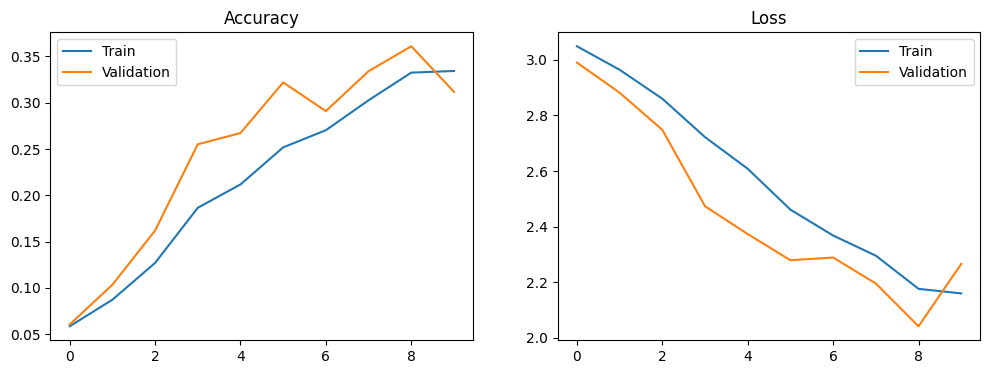

In [16]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()

plt.show()


Test Predictions 

In [17]:
y_true = []
y_pred = []

for images, batch_labels in test_ds:
    preds = model.predict(images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Test Accuracy 

In [18]:
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.35470941883767537


Classfication Report

In [19]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


              precision    recall  f1-score   support

    airplane       0.50      0.12      0.20        24
   ambulance       0.24      0.44      0.31        27
     bicycle       0.23      0.74      0.35        23
        boat       1.00      0.04      0.07        26
         bus       0.38      0.41      0.39        27
         car       0.86      0.24      0.38        25
  fire_truck       0.47      0.57      0.52        28
  helicopter       0.44      0.31      0.36        26
  hovercraft       0.53      0.31      0.39        26
     jet_ski       0.50      0.24      0.32        25
       kayak       0.25      0.15      0.19        26
  motorcycle       0.28      0.77      0.41        26
    rickshaw       0.21      0.50      0.30        22
     scooter       0.69      0.36      0.47        25
      segway       0.47      0.42      0.44        19
  skateboard       0.31      0.16      0.21        25
     tractor       0.44      0.41      0.42        27
       truck       0.29    

Confusion Matrix

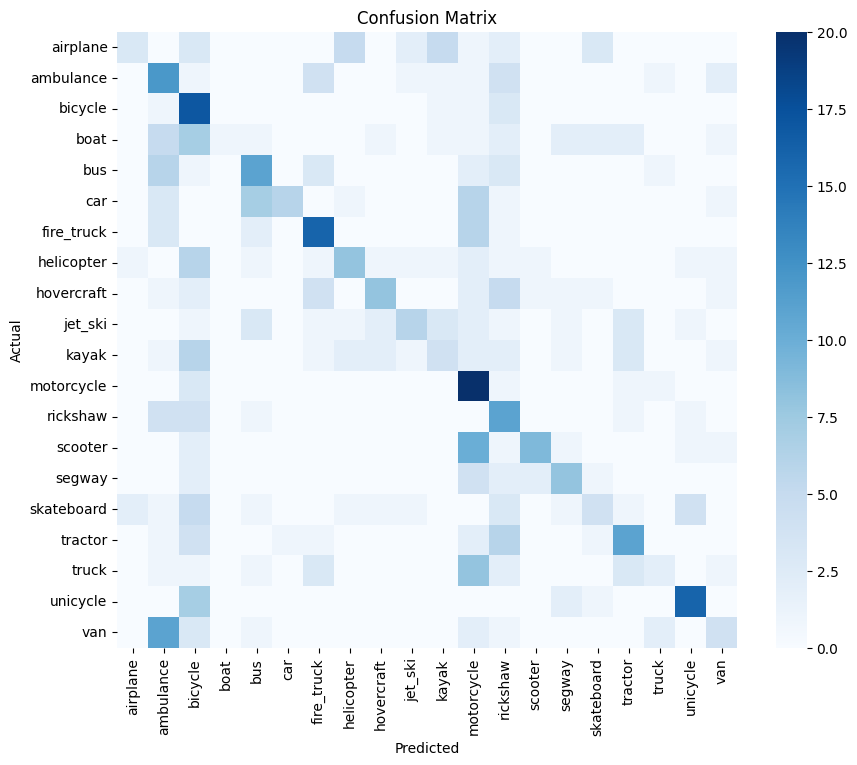

In [20]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues",
    annot=False
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
model.save("/kaggle/working/vehicle_cnn_model.h5")
